# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Quantifying-dominance-behaviors" data-toc-modified-id="Quantifying-dominance-behaviors-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quantifying dominance behaviors</a></div><div class="lev2 toc-item"><a href="#Dominance-behaviors-of-the-bx93-associated-class" data-toc-modified-id="Dominance-behaviors-of-the-bx93-associated-class-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dominance behaviors of the <em>bx93</em>-associated class</a></div><div class="lev2 toc-item"><a href="#Dominance-behaviors-of-the-sy622-associated-class" data-toc-modified-id="Dominance-behaviors-of-the-sy622-associated-class-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dominance behaviors of the <em>sy622</em>-associated class</a></div>

# Quantifying dominance behaviors
In this notebook, I will perform a dominance analysis on the two classes that require it, namely the *bx93*-associated class and the *sy622*-associated class. As usual, I first load all the libraries I need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import epistasis as epi
import scipy as scipy

from matplotlib import rc

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

Master variables

In [2]:
q = 0.1
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy  = pd.read_csv('../output/dpy_22_results.csv')

I will measure dominance class-wide by using a fairly standard trick. I will assume that all of the transcripts in the class are controlled via exactly the same mechanism. Then, it stands to reason that the dominance relationship between the two alleles should always be the same. Dominance will be defined in terms of expression level, and dominance is a continuous variable between 0 and 1. I will consider the expression of the heterozygote to be a linear combination of the expression levels of the two homozygotes, subject to the constraint that the mixing factors in the linear combination add up to unity. Mathematically, this can be expressed as:
$$
\beta_{sy622/bx93, i} = \hat{D} \cdot
         \begin{bmatrix}
           \beta_{sy622/sy622, i} \\
           \beta_{bx93/bx93, i} \\
         \end{bmatrix},
$$
where $\hat{D}$ contains the mixing factors, $d$ and $1-d$. For our system, I will ask that the same matrix $\hat{D}$ hold for all the transcripts $i$, since we want to believe that this class is a single phenotype, not a combination of them, and that phenotypes arise by a single mechanism. In this case, the problem can be expressed as a linear regression, where a single parameter, $d$ must be found. I will solve this linear regression using Bayes theorem. We will assume that errors are normally distributed in $\beta$ space, and that $d$ has a uniform prior. Then, I will numerically solve for the $d$ value that minimizes the negative logarithm of the likelihood. This is the Maximume Likelihood Estimate of the dominance coefficient.

In [3]:
def log_likelihood(d, x, y, xy, xy_se):
    """
    Assumes a Normal Distribution and returns the log-likelihood of the events given a parameter X
    
    Params:
    d - a number between 0 and 1
    x, y, xy - measurements
    xy_se - std of each point xy
    
    Output:
    log-likelihood
    """
    # calculate weighted average
    model = d*x + (1-d)*y
    
    chi2 = (xy - model)**2
    sigma = xy_se
    
    #return log model
    return  -(chi2/(2*sigma**2)).sum()

def neg_log_likelihood(d, x, y, xy, xy_se):
    return -log_likelihood(d, x, y, xy, xy_se)

## Dominance behaviors of the *bx93*-associated class

I will begin by finding the dominance coefficient of the *bx93*-associated class. First, I will extract all of the transcripts that are in this class, regardless of their q-values.

In [4]:
x = tidy[(tidy['phenotypic class'] == 'bx93 associated') & (tidy.strain == 'PS4087')].b.values
y = tidy[(tidy['phenotypic class'] == 'bx93 associated') & (tidy.strain == 'PS4187')].b.values
xy = tidy[(tidy['phenotypic class'] == 'bx93 associated') & (tidy.strain == 'PS4176')].b.values
se_xy = tidy[(tidy['phenotypic class'] == 'bx93 associated') & (tidy.strain == 'PS4176')].se_b.values

For simplicity, I will also define a plotting function called `dominance_distribution`. This distribution will plot the log-likelihood and show the $d$ value that maximizes it. It will also return the MLE estimate and the associated error of the MLE.

In [5]:
rxy = scipy.stats.spearmanr(x, y)
print('The correlation between PS4087 and PS4187 is {0:.2g}'.format(rxy.correlation))
rxxy = scipy.stats.spearmanr(x, xy)
print('The correlation between PS4087 and PS4176 is {0:.2g}'.format(rxxy.correlation))
ryxy = scipy.stats.spearmanr(y, xy)
print('The correlation between PS4187 and PS4176 is {0:.2g}'.format(ryxy.correlation))

The correlation between PS4087 and PS4187 is 0.82
The correlation between PS4087 and PS4176 is 0.84
The correlation between PS4187 and PS4176 is 0.9


In [6]:
def dominance_distribution(x, y, xy, se_xy):
    """
    Returns the dominance distribution for a set of measurements.
    """
    X = np.linspace(0, 1, 1000)
    Y = np.array([neg_log_likelihood(xi, x, y, xy, se_xy) for xi in X])
    
    if (np.abs(Y) > 2.5*10**3).any():
        print('Warning, log-likelihood has very large absolute values. Arbitrarily subtracting Y.mean() from Y')
        Y = Y - Y.mean()
    
    fig, ax = plt.subplots()
    if (np.abs(Y) > 10**3).any():
        print('Warning, after renormalization, the absolute likelihood values remain large. Plotting log-likelihood instead.')
        plt.plot(X, -Y)
        plt.xlabel(r'Fractional Dominance, $d$')
        plt.ylabel(r'$\log{P(d | Data)}$')
        mean = X[np.where(Y == Y.min())][0]
        
        # estimate the standard deviation:
        print('Estimating standard deviation. Estimation is not exact.')
        Yprime = Y[np.where(Y < 0.8*Y.min())] - Y.min()
        expY = np.exp(-Yprime)/np.exp(-Yprime).sum()
        std = np.sqrt(((X[np.where(Y < 0.8*Y.min())] - mean)**2*expY).sum())        
    else:
        expY = np.exp(-Y)/np.exp(-Y).sum() # normalize 
        mean = (expY*X).sum()
        std = np.sqrt(((X - mean)**2*expY).sum())

        plt.plot(X, expY)
        plt.xlabel(r'Fractional Dominance, $d$')
        plt.ylabel(r'$P(d | Data)$')

    plt.axvline(mean, color='red', ls='--')
    
    return mean, std

Let's go ahead and calculate $d$ for the *sy622* allele in the *bx93*-associated class:

Warning, log-likelihood has very large absolute values. Arbitrarily subtracting Y.mean() from Y
Warning, after renormalization, the absolute likelihood values remain large. Plotting log-likelihood instead.
Estimating standard deviation. Estimation is not exact.
dominance: 0.19 +/- 0.01


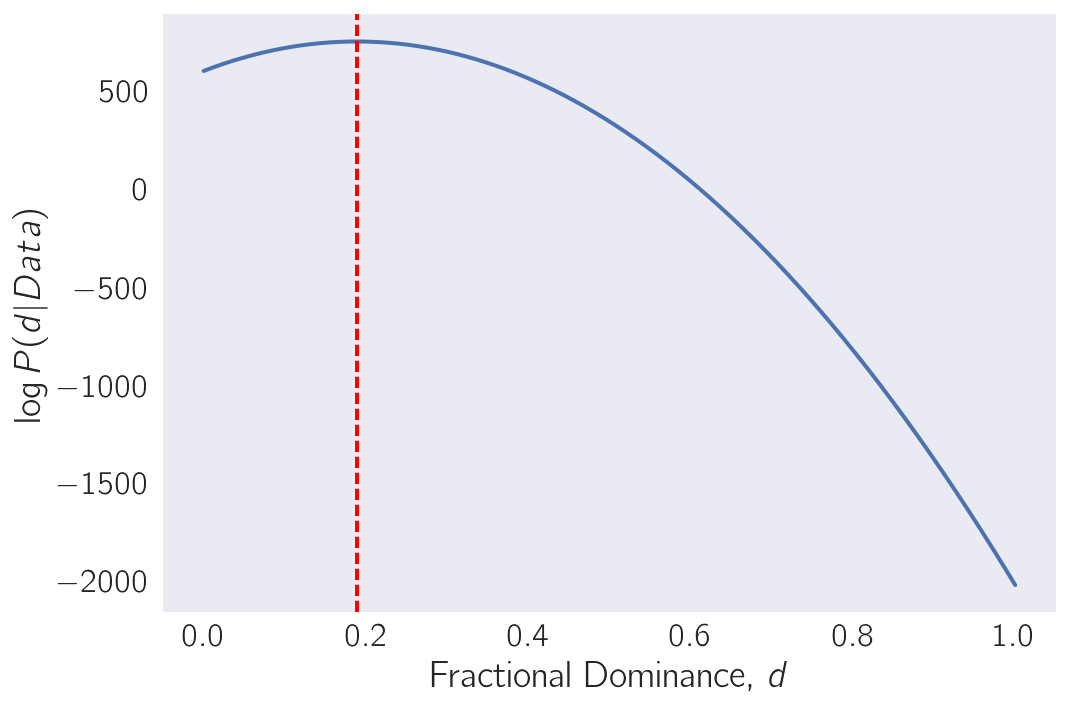

In [7]:
mean, std = dominance_distribution(x, y, xy, se_xy)
print('dominance: {0:.2f} +/- {1:.2f}'.format(mean, std))

Next, I would also like to make a plot of the predicted expression level, $\hat{D} \cdot \hat{\beta}_{i/i}$,  vs the observed expression level of the heterozygote, $\beta_{i/j}$. This plot is diagnostic, in the sense that the points should show linear behavior with no systematic residuals. If this is the case, we may be more inclined to believe there is a single dominance coefficient. For this plot, I will color the points according to the local density of the points in the graph (yellow for high density/ purple for low) and I will make the size of the point inversely proportional to some measurement of the uncertainty in the observed coefficients. The more certainty we have in a given point, the larger it will be.

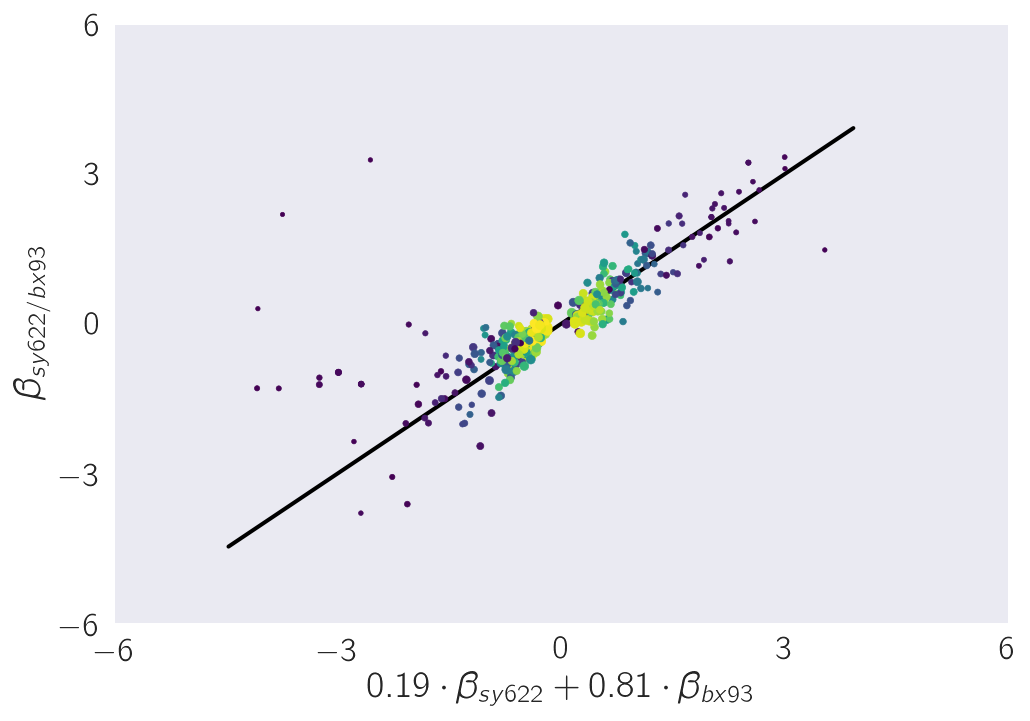

In [8]:
def density_color(x, y):
    points = np.vstack([x, y])
    z = scipy.stats.gaussian_kde(points)(points)
    return z

def dominance_plot(x, y, xy, se_xy, mixing_factor, s0=3, **kwargs):
    """Given a set of measurements and a mixing factor, make a dominance plot"""
    size = np.sqrt(se_xy)
    
    fig, ax = plt.subplots()
    ax.scatter(mixing_factor*x + (1-mixing_factor)*y, xy, s=s0/size, **kwargs)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(lims, lims, 'k-', alpha=1, zorder=0)

    plt.xlabel(r'${0:.2g}\cdot \beta_{{sy622}} + {1:.2g}\cdot\beta_{{bx93}}$'.format(mean, 1-mean))
    plt.ylabel(r'$\beta_{{sy622/bx93}}$')
    
    return ax

density = density_color(x, y)
ax = dominance_plot(x, y, xy, se_xy, 0.2, alpha=1, cmap='viridis', c=density, s0=5)

plt.xticks([-6, -3, 0, 3, 6])
plt.yticks([-6, -3, 0, 3, 6])

plt.savefig('../output/bx93_associated_dominance.svg', bbox_inches='tight')

For the most part, it looks good! Couple of far off points, but those are quite small, indicating high variance and therefore high uncertainty. It seems there really might only be a single dominance behavior for this class. 

## Dominance behaviors of the *sy622*-associated class

In [9]:
x = tidy[(tidy['phenotypic class'] == 'sy622 associated') & (tidy.strain == 'PS4087')].b.values
y = tidy[(tidy['phenotypic class'] == 'sy622 associated') & (tidy.strain == 'PS4187')].b.values
xy = tidy[(tidy['phenotypic class'] == 'sy622 associated') & (tidy.strain == 'PS4176')].b.values
se_xy = tidy[(tidy['phenotypic class'] == 'sy622 associated') & (tidy.strain == 'PS4176')].se_b.values

In [10]:
rxy = scipy.stats.spearmanr(x, y)
print('The correlation between PS4087 and PS4187 is {0:.2g}'.format(rxy.correlation))
rxxy = scipy.stats.spearmanr(x, xy)
print('The correlation between PS4087 and PS4176 is {0:.2g}'.format(rxxy.correlation))
ryxy = scipy.stats.spearmanr(y, xy)
print('The correlation between PS4187 and PS4176 is {0:.2g}'.format(ryxy.correlation))

The correlation between PS4087 and PS4187 is 0.85
The correlation between PS4087 and PS4176 is 0.95
The correlation between PS4187 and PS4176 is 0.87


Warning, log-likelihood has very large absolute values. Arbitrarily subtracting Y.mean() from Y
Warning, after renormalization, the absolute likelihood values remain large. Plotting log-likelihood instead.
Estimating standard deviation. Estimation is not exact.
dominance: 0.45 +/- 0.01


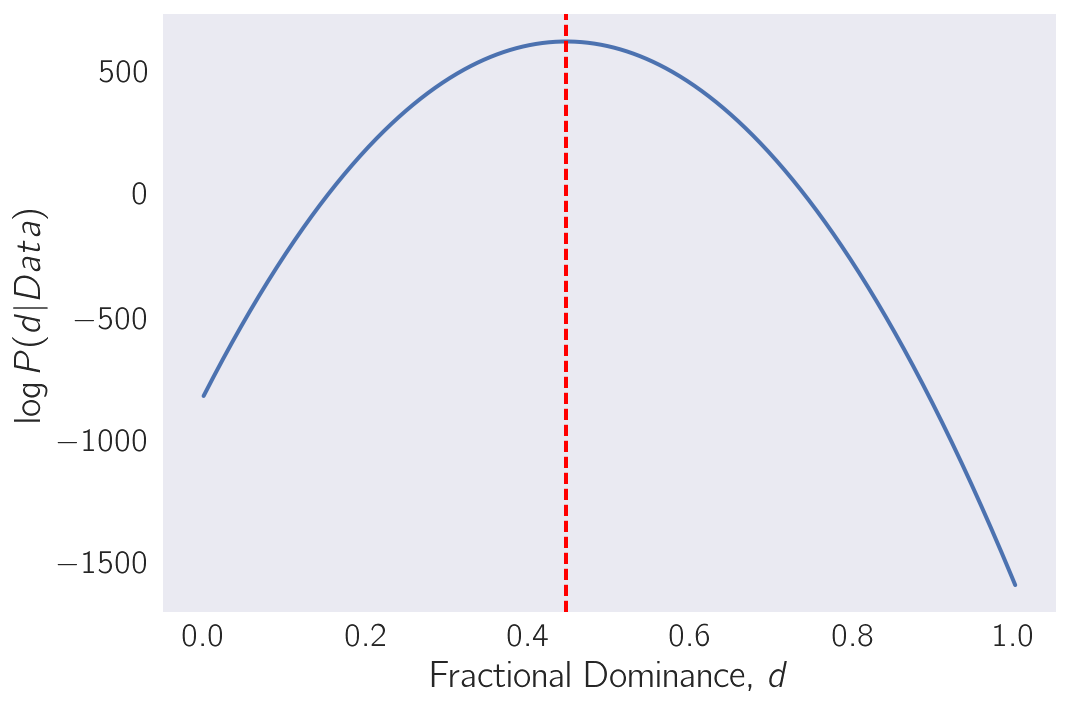

In [11]:
mean, std = dominance_distribution(x, y, xy, se_xy)
print('dominance: {0:.2f} +/- {1:.2f}'.format(mean, std))

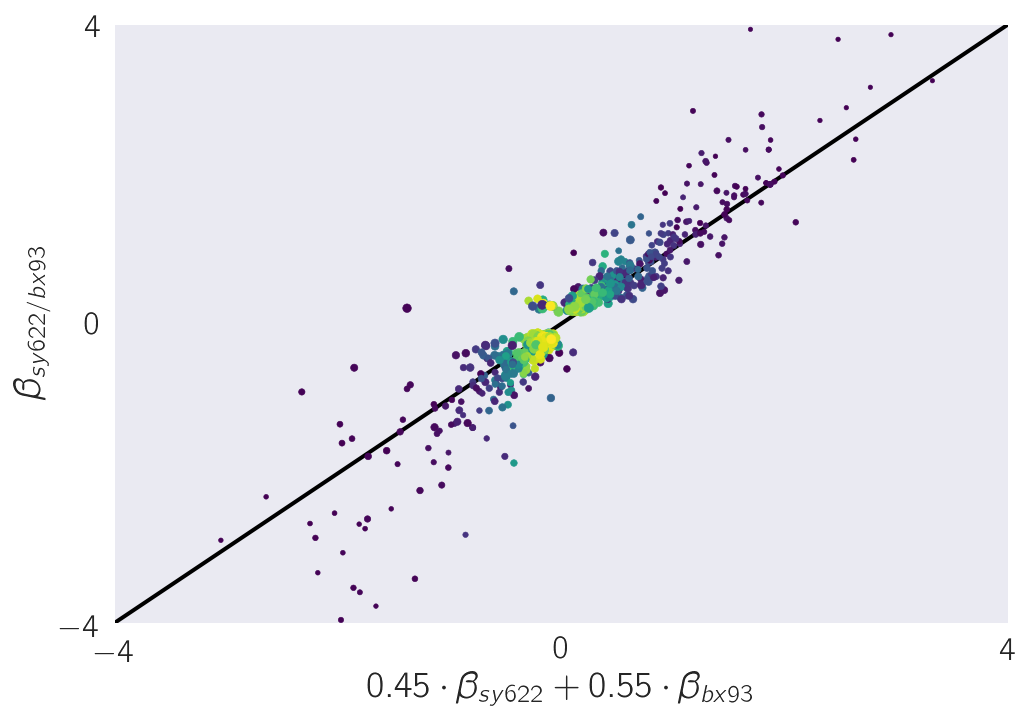

In [12]:
density = density_color(x, y)
ax = dominance_plot(x, y, xy, se_xy, mean, alpha=1, c=density, cmap='viridis', s0=5)

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xticks([-4, 0, 4])
plt.yticks([-4, 0, 4])

plt.savefig('../output/sy622_associated_dominance.svg', bbox_inches='tight')